# Example of Full Synthetic Viscoelastic Problem Analysis Process

In this notebook, a problem is tackled with the *DeepMoD* protocol concerning the ODEs involved in problems of linear viscoelasticity. The notebook will proceed with the following structure:

1. Firstly, the response of a defined viscoelastic material will be numerically calculated using Boltzmann superposition integrals.

2. Next, this data will be processed such that it is scaled appropriately and a random subset of points are taken from the master data set.

3. After this, *DeepMoD* will be configured.

4. The *DeepMoD* protocol is run.

5. Finally, all results will be extracted, organised and saved.

Along the way, many additional steps will be present for analyzing the ongoing progress of the process, including in particular sections where numerical derivatives are used to check agreement between a given ODE and a given data set.

In [1]:
import os
import sys
from datetime import datetime
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch

sys.path.append('../src')
import deepymod_torch.VE_datagen as VE_datagen
import deepymod_torch.VE_params as VE_params
from deepymod_torch.DeepMod import run_deepmod

np_seed = 2
torch_seed = 0
np.random.seed(np_seed)
torch.manual_seed(torch_seed)

## Data generation

Firstly, the mechanical model is defined. The definition is done with 3 steps. First the mechanical model type is chosen between GMM or GKM. Then, a list of eleastic moduli is defined in the form [$E_0$, $E_1$, $E_2$, ...]. Finally a list of paired viscosities are defined in the form [$\eta_1$, $\eta_2$, ...]. For the purposes of data generation, if the manipulation variable is Strain, the definition of a model as a GMM is mandatory. Similarly, if the manipulation variable is Stress, the definition of a model as a GKM is mandatory. If this does not match the desired test, conversion between models is required. This can be accomplished using `convert_between_models(...)` from VE_params.py .

In [20]:
input_type = 'Strain'
mech_model = 'GMM'
    
E = [0.61, 1.18, 1.61, 10**-30]
eta = [1.59, 17.88, 10**-20]
sum(E)

3.4000000000000004

In [21]:
VE_params.coeffs_from_model_params(E, eta, 'GMM', print_expressions=True)

E^M_0*E^M_1*E^M_2*E^M_3/(E^M_0*E^M_1*E^M_2*eta^M_3 + E^M_0*E^M_1*E^M_3*eta^M_2 + E^M_0*E^M_2*E^M_3*eta^M_1 + E^M_1*E^M_2*E^M_3*eta^M_1 + E^M_1*E^M_2*E^M_3*eta^M_2 + E^M_1*E^M_2*E^M_3*eta^M_3)

(E^M_0*E^M_1*eta^M_2*eta^M_3 + E^M_0*E^M_2*eta^M_1*eta^M_3 + E^M_0*E^M_3*eta^M_1*eta^M_2 + E^M_1*E^M_2*eta^M_1*eta^M_3 + E^M_1*E^M_2*eta^M_2*eta^M_3 + E^M_1*E^M_3*eta^M_1*eta^M_2 + E^M_1*E^M_3*eta^M_2*eta^M_3 + E^M_2*E^M_3*eta^M_1*eta^M_2 + E^M_2*E^M_3*eta^M_1*eta^M_3)/(E^M_0*E^M_1*E^M_2*eta^M_3 + E^M_0*E^M_1*E^M_3*eta^M_2 + E^M_0*E^M_2*E^M_3*eta^M_1 + E^M_1*E^M_2*E^M_3*eta^M_1 + E^M_1*E^M_2*E^M_3*eta^M_2 + E^M_1*E^M_2*E^M_3*eta^M_3)

eta^M_1*eta^M_2*eta^M_3*(E^M_0 + E^M_1 + E^M_2 + E^M_3)/(E^M_0*E^M_1*E^M_2*eta^M_3 + E^M_0*E^M_1*E^M_3*eta^M_2 + E^M_0*E^M_2*E^M_3*eta^M_1 + E^M_1*E^M_2*E^M_3*eta^M_1 + E^M_1*E^M_2*E^M_3*eta^M_2 + E^M_1*E^M_2*E^M_3*eta^M_3)

E^M_1*E^M_2*E^M_3/(E^M_0*E^M_1*E^M_2*eta^M_3 + E^M_0*E^M_1*E^M_3*eta^M_2 + E^M_0*E^M_2*E^M_3*eta^M_1 + E^M_1*E^M_2*E^M_3*eta^M_1 + E^M_1*E^M_2*E^M_3*eta^M_2 + E^M_1*E^M_2*E^M_3*eta^M_3)

(E^M_1*E^M_2*eta^M_3 + E^M_1*E^M_3*eta^M_2 + E^M_2*E^M_3*eta^M_1)/(E^M_0*E^M_1*E^M_2*eta^M_3 + E^M_0*E^M_1*E^M_3*eta^M_2 + E^M_0*E^M_2*E^M_3*eta^M_1 + E^M_1*E^M_2*E^M_3*eta^M_1 + E^M_1*E^M_2*E^M_3*eta^M_2 + E^M_1*E^M_2*E^M_3*eta^M_3)

(E^M_1*eta^M_2*eta^M_3 + E^M_2*eta^M_1*eta^M_3 + E^M_3*eta^M_1*eta^M_2)/(E^M_0*E^M_1*E^M_2*eta^M_3 + E^M_0*E^M_1*E^M_3*eta^M_2 + E^M_0*E^M_2*E^M_3*eta^M_1 + E^M_1*E^M_2*E^M_3*eta^M_1 + E^M_1*E^M_2*E^M_3*eta^M_2 + E^M_1*E^M_2*E^M_3*eta^M_3)

eta^M_1*eta^M_2*eta^M_3/(E^M_0*E^M_1*E^M_2*eta^M_3 + E^M_0*E^M_1*E^M_3*eta^M_2 + E^M_0*E^M_2*E^M_3*eta^M_1 + E^M_1*E^M_2*E^M_3*eta^M_1 + E^M_1*E^M_2*E^M_3*eta^M_2 + E^M_1*E^M_2*E^M_3*eta^M_3)

[9.99999995562892e-11,
 44.3710802875772,
 83.4076404687226,
 1.63934425502113e-10,
 1.63934425706262,
 20.4148321892973,
 24.5316589613890]

In [19]:
if (mech_model == 'GMM' and input_type == 'Stress') or (mech_model == 'GKM' and input_type == 'Strain'):
    solutions, dest_model_syms = VE_params.convert_between_models(E, eta, mech_model)
    E, eta = solutions[0] # Use first solution by default.
    mech_model = 'GMM' if mech_model == 'GKM' else 'GKM' # model used is now the alternative

This code block simply calculates and displays some characteristic times of the defined model. If the model was a GMM, these times will be the relaxation decay times. If the model was a GKM, they will be the creep times. Relaxation decay time for a GKM and creep time for a GMM is not defined in the same way.

In [4]:
tau = np.array(eta)/np.array(E[1:])
tau

array([ 1.34745763, 11.10559006,  1.        ])

Here the manipulation profile is analytically described. It is here accomplished using Python's lambda functions, but could equally be full functions. The first 2 lambda functions, `input_expr` and `d_input_expr` are necessary for data generation, whereas the third lambda function, `input_torch_lambda`, is required for calculation of part of the library later on. It should be identical to `input_expr`, save for the conversion of all functions to torch functions that can accept and preserve tensors with tracked gradients. It is defined here for convenience. `d_input_expr` is a lambda function that returns the result of the analytical expression for the first derivative of the analytical expression found as `input_expr`.

func_desc is purely for record keeping.

In [5]:
func_desc = 'Half Sinc'

# sinc
omega = 1
amp = 7
input_expr = lambda t: amp*np.sin(omega*t)/(omega*t)
d_input_expr = lambda t: (amp/t)*(np.cos(omega*t) - np.sin(omega*t)/(omega*t))
input_torch_lambda = lambda t: amp*torch.sin(omega*t)/(omega*t)

# # funny
# omega_1 = 0.9; omega_2 = 7.2; omega_3 = 2.4*np.pi
# amp_1 = 4; amp_2 = amp_1; amp_3 = 0.5
# input_expr = lambda t: amp_1*(1-np.exp(-omega_1*t)) + amp_2*(1-np.exp(-omega_2*t)) + amp_3*np.sin(omega_3*t)
# d_input_expr = lambda t: amp_1*omega_1*np.exp(-omega_1*t) + amp_2*omega_2*np.exp(-omega_2*t) + amp_3*omega_3*np.cos(omega_3*t)
# input_torch_lambda = lambda t: amp_1*(1-torch.exp(-omega_1*t)) + amp_2*(1-torch.exp(-omega_2*t)) + amp_3*torch.sin(omega_3*t)

A list is here defined purely for the purpose of saving all of the parameters just used to construct the model and manipulation. It is written here as the nature of manipulation chosen may affect which items in the list are desired, so it is the logical place to write it out and adjust it. The list will be saved after DeepMoD is run.

In [6]:
dg_info_list = [f'Model: '+mech_model, f'E: {E}', f'eta: {eta}', 'Input: '+input_type, 'Desc: '+func_desc, f'omega: {omega}', f'Amp: {amp}']

The independant data points (time) over which to synthesise the data are specified. In this example, 5 total oscillations of the sine wave within the manipulation included as $10 \pi / \omega = 5T$. As $sin(x)/x$ is used, there is a discontinuity at $t=0$, so the first time point is shortly after. This time series is shaped into a column vector.

In [7]:
time_array = np.linspace(10**-10, 10*np.pi/omega, 5000).reshape(-1, 1)

Here the response is calculated, as well as the manipulation evaluated at each given time point. The manipulation array is calculated by simply supplying teh time points to the manipulation expressions, whereas the response array is obtained the much more complex method involving Boltzmann superposition integrals which incorporate the model and manipulation description within the mathematics. The evaluated manipulation is not used in the major narrative, but is used for plotting and analysis. The shape of both arrays returned will match the time array, so will be column vectors also.

In [8]:
manipulation_array_1 = input_expr(time_array)
response_array_1 = VE_datagen.calculate_strain_stress(input_type, time_array, input_expr, d_input_expr, E, eta)
strain_array_1, stress_array_1 = (manipulation_array_1, response_array_1) if input_type == 'Strain' else (response_array_1, manipulation_array_1)

In [9]:
E = [1, 1, 1]
eta = [2.5, 15]

manipulation_array_2 = input_expr(time_array)
response_array_2 = VE_datagen.calculate_strain_stress(input_type, time_array, input_expr, d_input_expr, E, eta)
strain_array_2, stress_array_2 = (manipulation_array_2, response_array_2) if input_type == 'Strain' else (response_array_2, manipulation_array_2)

The results of the above are plotted against time.

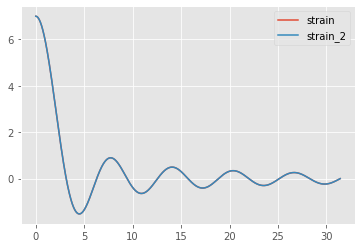

In [10]:
plt.plot(time_array.flatten(), strain_array_1.flatten(), label='strain')
plt.plot(time_array.flatten(), strain_array_2.flatten(), label='strain_2')
plt.legend()

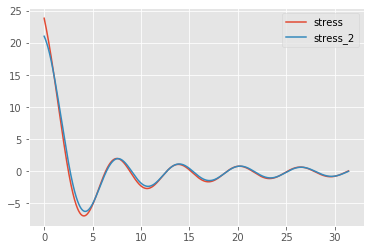

In [11]:
plt.plot(time_array.flatten(), stress_array_1.flatten(), label='stress')
plt.plot(time_array.flatten(), stress_array_2.flatten(), label='stress_2')
plt.legend()

### GDM coefficients and generation validation (extra)

Here the accuracy of the data calculated is verified, by comparing the stress and strain profiles using the theoretically correct ODE. First, the coefficients of the ODE are obtained, the equation rearranged such that the coefficient of the first derivative of strain is 1. The returned list always lists the coefficients attached to strain first, omitting the coefficient of 1 attached to the first derivative, then lists the coefficients attached to stress. Hence the list will always have an odd number of terms, the first item will always be the coefficient of strain, and the middle item will always be the coefficient of stress. Each additional viscosity included in the mechanical model definition increases the maximum order of derivative contained within the GDM by 1, and so the number of terms is (#viscosities + 1)*2 - 1.

The kwarg `print_expressions=True` can be added to show the equations used to relate the mechanical model definition to these coefficients.

For this and any use of functions within VE_params.py, the SymPy package must be installed.

In [11]:
unscaled_coeffs = VE_params.coeffs_from_model_params(E, eta, mech_model)
unscaled_coeffs

[0.0285714285714286,
 3.21428571428571,
 0.0285714285714286,
 0.500000000000000,
 1.07142857142857]

**Extra:**
The verification is conducted by numerically obtaining all relevant derivatives, and calculating the residual of the ODE (the GDM) at each point. The magnitude of the residual at each point is plotted on a log scale.

Due to the imperfect nature of numerical derivatives, even on noise free data, the residuals are never 0.

In [12]:
errors = VE_datagen.equation_residuals(time_array, strain_array, stress_array, unscaled_coeffs)

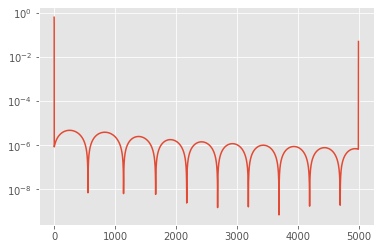

In [13]:
plt.semilogy(abs(errors.flatten()))

## Data Treatment

### Scaling

Here the various scaling of the 3 data series occurs. In the case of the manipulation and response variables, this scaling is for the purpose of normalization, to bring the full range of magnitudes to span -1 to 1. This is optimal for performance of the optimisation process and for reducing the affects of disproportionately noisy data where this is a concern. In this example, it is not, as no noise is included.

In the case of the time series data, the scaling is such as to bring the angular frequency of the sine function within sinc to an effective value of 1.2. This has been found to be empirically important. The exact reason for this is not known, but it corresponds to the scaling of a sinc curve where the average values of the different orders of derivative are most similar.

`scaled_input_torch_lambda` is defined to accomplish normalization for the manipulation variable, effectively scaling the previously defined expression to map scaled time to scaled manipulation variable, rather then simply time to variable.

`scaled_input_expr` and whichever of `scaled_strain_array` or `scaled_stress_array` is not also named `scaled_target_array` are not used in the major narrative of this example.

In [14]:
# 'normalising'
time_sf = omega/1.2
strain_sf = 1/np.max(abs(strain_array))
stress_sf = 1/np.max(abs(stress_array))

scaled_time_array = time_array*time_sf
scaled_strain_array = strain_array*strain_sf
scaled_stress_array = stress_array*stress_sf
if input_type == 'Strain':
    scaled_input_expr = lambda t: strain_sf*input_expr(t/time_sf)
    scaled_input_torch_lambda = lambda t: strain_sf*input_torch_lambda(t/time_sf)
    scaled_target_array = scaled_stress_array
elif input_type == 'Stress':
    scaled_input_expr = lambda t: stress_sf*input_expr(t/time_sf)
    scaled_input_torch_lambda = lambda t: stress_sf*input_torch_lambda(t/time_sf)
    scaled_target_array = scaled_strain_array

#### Predicting Coefficients

With rescaled data series, the viscoelastic data series are now governed by a different ODE. The coefficients for this equation can be found by scaling the previous coefficients. It is these coefficients that *DeepMoD* should find.

In [15]:
expected_coeffs = VE_params.scaled_coeffs_from_true(unscaled_coeffs, time_sf, strain_sf, stress_sf)
expected_coeffs

[0.0342857142857143,
 2.67857142857143,
 0.102857142857143,
 1.50000000000000,
 2.67857142857143]

#### Extra: Scaling Validation

To verify that no mistake has been made during the scaling process, the same process as before is repeated, combining the scaled data series and teh scaled theoretical GDM equation.

These residuals may well not be the same as before as the residuals will be scaled by the same factor as the first derivative of strain, with its coefficient held at 1.

In [16]:
errors = VE_datagen.equation_residuals(scaled_time_array, scaled_strain_array, scaled_stress_array, expected_coeffs)

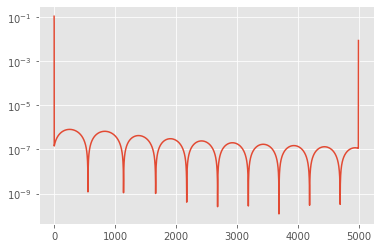

In [17]:
plt.semilogy(abs(errors.flatten()))

### Extra: Magnitude of expected term-normalized coefficients

Important in the *DeepMoD* protocol is the calculation of the quantities here termed the term-normalized coefficients. In this process, each coefficient is multiplied by the norm of all instances of its attached term for all time points. This establishes a fairer assessment of the term-cofficient combination's contribution to the working model. This quantity is used when the threshold criterion is applied. It is possible that the the correct GDM contains terms that are small enough to fail this threshold criterion. If this is the case, retention of these terms in the discovered model should not be expected, confounding the recovery of the original mechanical model.

This calculation is accomplished by assembling the parts necessary to use the same function as used within *DeepMoD* for this process, namely numerically calculating derivatives from the generated data, organizing the results into a library, and converting all necessary objects to tensors.

In [18]:
from deepymod_torch.sparsity import scaling_single_vec

In [19]:
exp_diff_order_sc = len(eta)

# Get time_deriv and sparse_theta
theta_strain_sc = VE_datagen.num_derivs(scaled_strain_array, scaled_time_array, exp_diff_order_sc)
theta_stress_sc = VE_datagen.num_derivs(scaled_stress_array, scaled_time_array, exp_diff_order_sc)
time_deriv_sc = [torch.tensor(theta_strain_sc[:, 1:2], dtype=torch.float32)]
sparse_theta_array_sc = np.concatenate((theta_strain_sc[:, :1], theta_strain_sc[:, 2:], theta_stress_sc), axis=1)
sparse_theta_sc = torch.tensor(sparse_theta_array_sc, dtype=torch.float32)

# Get exp coeffs
expected_coeffs_sc = torch.tensor(expected_coeffs, dtype=torch.float32).reshape(-1, 1)

In [20]:
scaling_single_vec(expected_coeffs_sc, sparse_theta_sc, time_deriv_sc[0])

tensor([[0.0501],
        [2.4615],
        [0.1364],
        [1.5885],
        [2.2831]])

### Noise

This example contains no noise. However, if noise is to be added it can be added here. In this implementation, `noise_level` scales a normally distributed addition to the response data, already also scaled by the range of magnitudes contained within the data set. No noise is applied here to the manipulation variable.

For the sake of consistant use of the NumPy random seed, always leave this line uncommented even if `noise_level` is 0.

In [21]:
# add noise
noise_level = 0

noisy_target_array = scaled_target_array + noise_level * np.std(scaled_target_array) * np.random.standard_normal(scaled_target_array.shape)

### Random Sampling

Here a random subset of the generated and processed data is selected. A shuffled set of indices is generated and then an initial subset of these is used to pick the data from the generated and processed data.

In [22]:
# sampling
number_of_samples = 1000

reordered_row_indices = np.random.permutation(scaled_time_array.size)

reduced_time_array = scaled_time_array[reordered_row_indices, :][:number_of_samples]
reduced_target_array = noisy_target_array[reordered_row_indices, :][:number_of_samples]

## Configuration of *DeepMoD*

### Defining Library

Here, the function necessary for the computation of the library of terms for *DeepMoD* to select from is defined. This function will be called every epoch to generate the most up to date version of this library. In this example, the function computes and returns the derivatives of stress and strain up to a specified order using the automatic differentiation capabilities of the PyTorch framework. `auto_deriv(...)` is a general function for computing automatic derivatives up to a given order, and `mech_library(...)` organizes the results. In this example with synthetic data, the strain 'half' of the library can be computed in advance as it is invariable throughout the process. It is supplied as an argument to the library function. Following the convention established within the structure of *DeepMoD*, the left hand side of the equation being discovered is a mandatory term and not part of the library. It is returned as its own object, enclosed within a list.

In [23]:
import torch.autograd as auto
    
def mech_library(inputs, **library_config):
    '''
    Library function for the problem of linear viscoelasticity. Calculates all derivatives up to a specified order for strain and stress.
    The first derivative of strain is returned as the mandatory guiding side of the discovered model.
    All terms calculated from strain in the returned library are multiplied by -1.
    
    Parameters
        inputs: 2-tuple
            A tuple of (prediction, data) where both are Nx1 tensors and gradients have been tracked from data to prediction.
            The tensor, data, is the input to a neural network, whereas prediction is the output.
        **library_config: kwargs packed into dict.
            All additional configuration options. Mandatory is the inclusion of diff_order=int, input_type=string, and input_theta=2D tensor.
            input_type must be either 'Strain' or 'Stress'
            input_theta contains the library terms for the manipulation variable, including the first strain derivative if strain is the manipulation variable.
            input_theta is therefore Nx(diff_order+1) always.
            
    Returns
        [strain_t]: list
            Contains a Nx1 tensor
        theta: Nx(2*diff_order + 1) tensor
    '''
    
    prediction, data = inputs
    
    # Load already calculated derivatives of manipulation variable
    input_theta = library_config['input_theta']
    if data.shape[0] == 1: # Swaps real input_theta out for dummy in initialisation pass.
        input_theta = torch.ones((1, input_theta.shape[1]))
    
    # Automatic derivatives of response variable 
    output_derivs = auto_deriv(data, prediction, library_config['diff_order'])
    output_theta = torch.cat((prediction, output_derivs), dim=1)
    
    # Identify the manipulation/response as Stress/Strain and organise into returned variables
    if library_config['input_type'] == 'Strain':
        strain = input_theta
        stress = output_theta
    else: # 'Stress'
        strain = output_theta
        stress = input_theta
        
    strain_t = strain[:, 1:2] # Extract the first time derivative of strain
    strain = torch.cat((strain[:, 0:1], strain[:, 2:]), dim=1) # remove this before it gets put into theta
    strain *= -1 # The negatives of all strain terms are included in the library so that all coefficients discovered should be positive.
    theta = torch.cat((strain, stress), dim=1)
    
    return [strain_t], theta


def auto_deriv(data, prediction, max_order):
    '''
    Computes all derivatives up to a specified order using automatic differentiation for a single input and a single output of a neural network.
    If it is desired to calculate the derivatives of different predictions wrt different data, this function must be called multiple times.
    
    Parameters
        data: Nx1 tensor
            An input to the neural network.
        prediction: Nx1 tensor
            An output of the neural network.
        max_order: float
            Specifies the order up to which derivatives should be calculated.

    Returns
        derivs: Nxmax_order tensor
            No column with the zeroth derivative (the prediction).
    '''
    
    # First derivative builds off prediction.
    derivs = auto.grad(prediction, data, grad_outputs=torch.ones_like(prediction), create_graph=True)[0]
    for _ in range(max_order-1):
        # Higher derivatives chain derivatives from first derivative.
        derivs = torch.cat((derivs, auto.grad(derivs[:, -1:], data, grad_outputs=torch.ones_like(prediction), create_graph=True)[0]), dim=1)
            
    return derivs

### Conversion to PyTorch tensors

The correctly processed arrays are converted here to Tensors, the class of object used by the PyTorch framework. The time tensor must have the `requires_grad=True` flag as derivatives with respect to time are required for computation of the library. The target does not require this flag as it is solely used when computing the MSE loss and no derivative with respect to it is ever required.

In [24]:
time_tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
target_tensor = torch.tensor(reduced_target_array, dtype=torch.float32)

### Manipulation variable library advance calculation

In this synthetic example, the manipulation is precisely defined in advance and so it, and all its derivatives, are invariable throughout the training process and can be calculated in advance. Derivatives are obtained through automatic differentiation using the lambda function defined using torch functions for this purpose. `input_data` contains `time_tensor` in its history and so all derivatives of the manipulation variable required for the library can be calculated and organised.

In [25]:
library_diff_order = 3

input_data = scaled_input_torch_lambda(time_tensor)
input_derivs = auto_deriv(time_tensor, input_data, library_diff_order)
input_theta = torch.cat((input_data.detach(), input_derivs.detach()), dim=1)

### Threshold definition

The threshold criterion is evaluated at the point of selecting terms and is evaluated by using the result of a function which invariably takes the arguments `coeff_vector_scaled, coeff_vector, optim_config`, where `coeff_vector_scaled` is the term-normalized set of coefficients at the point of sparse selection, `coeff_vector` is the actual values of the coefficients within the working model at the point of sparse selection, and `optim_config` is a dictionary that is soon to be defined for the purpose of configuring the optmization behavior of *DeepMoD*.

`coeff_vector_scaled` is compared to the value of the result to determine the sparse selection. In this example this value is always 0.05, regardless of the arguments, and so all args are packed and never used.

In [26]:
percent = 0.05
def thresh_pc(*args): # Keep as full function so that it can be pickled
    return percent

### Definition of configuration dictionaries

Here, a series of parameters are set that affect the neural network initialization, the optimization process, the behavior and functionality of the library evaluation, and the progress reporting.  Only `library_config` is strictly required to avoid errors as its elements are required for the functioning of the library function above. All other dictionaries contain only elements which will be added if missing and contain default values.

This dictionary is important for configuration of the process of building the library. In this example the elements within the dictionary are:

* `'library_func'`: The function defined in this notebook scripting the process of building the library.

* `'diff_order'`: The maximum order of derivative to be included in the library for both strain and stress. This value matches that defined above when calculating the manipulation variable library in advance.

* `'coeff_sign'`: Triggers 2 things within the *DeepMoD* protocol. First, all initial values for the coefficients in the working model are made to be positive. Second, this status is encouraged throughout the optimization process by the inclusion of the sign loss, or $L_{\pm}$, set to introduce a penalty for coefficients that become negative.

* `'input_type'`: Specifies whether the manipulation variable was strain or stress, important purely for ensuring that the columns within the library are in the conventional order, with terms referring to strain first.

* `'input_theta'`: The strain 'half' of the library, calculated in advance.

With `mech_library(...)` as the value for the `'library_func'` key, all elements but `'coeff_sign'` must be included. Seperately, the sign loss is required, and so for this reason `'coeff_sign'` is also a required element.

In [27]:
library_config = {'library_func': mech_library,
                  'diff_order': library_diff_order,
                  'coeff_sign': 'positive',
                  'input_type': input_type,
                  'input_theta': input_theta}

This dictionary is important for configuration of the neural network initialization. Only elements for which the default values are not desired in this example are defined here.

* `'hidden_dim'`: Specifies the number of neurons in each hidden layer of the neural network.

In [28]:
network_config = {'hidden_dim': 30}

This dictionary is important for configuration of the optimization process. Only elements for which the default values are not desired in this example are defined here.

* `'lr_coeffs'`: The learning rate is an important parameter for the Adam optimizer used in *DeepMoD* and can also be called $\alpha$. Seperate values for the learning rates for the neural network parameters and coefficients in the working model can be defined. In this case the latter is set higher than its default.

* `'thresh_func'`: The function defined in the notebook scripting the evaluation of the threshold criterion.

* `'l1'`: The scale factor applied to the L1 loss term, sometimes also called $\lambda$. This term is used to encourage sparsity. In this example, it is set smaller than the default.

In [29]:
optim_config = {'lr_coeffs': 0.002,
                'thresh_func': thresh_pc,
                'l1': 10**-6,
                'PINN': True}

This dictionary is important for configuration of progress reporting. Only elements for which the default values are not desired in this example are defined here.

* `'plot'`: Specifies whether plots of the target and working prediction should be displayed in an IPython environment.

In [30]:
report_config = {'plot': True}

## Launching *DeepMoD*

In [31]:
expected_coeffs # Displayed here purely for convenience of comparison with working model.

[0.0342857142857143,
 2.67857142857143,
 0.102857142857143,
 1.50000000000000,
 2.67857142857143]

The training process is now launched using the wrapper function `run_deepmod(...)` which handles all configuration options so far defined. Aside from these dictionaries, only the input tensor and target need be supplied as arguments. In this example, all dictionaries are included as arguments, but in general only `library_config` is mandatory.

Upon completion, all training will have occurred both before and after the sparse selction and a model will have been reached. The returned object, `model`, is a member of a custom class of objects called DeepMod objects which are a subclass of the nn.Module class from PyTorch. The object is complex and contains the trained neural network amongst other characteristics such as many attributes relevant to the training process.

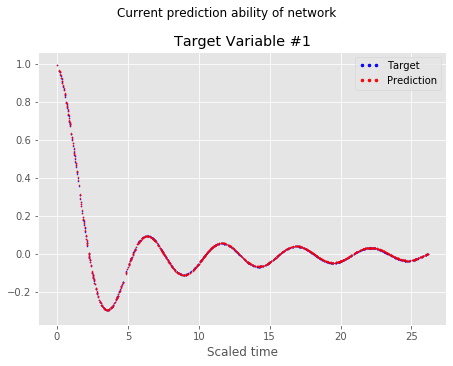

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |     Sign |
     100000    100.00%               0s   4.96e-06   3.04e-06   1.92e-06   0.00e+00   0.00e+00 
[Parameter containing:
tensor([[1.3881e-02],
        [1.7466e-01],
        [3.5717e-04],
        [2.3689e-01],
        [1.1936e+00],
        [2.2971e-01],
        [9.9600e-02]], requires_grad=True)]


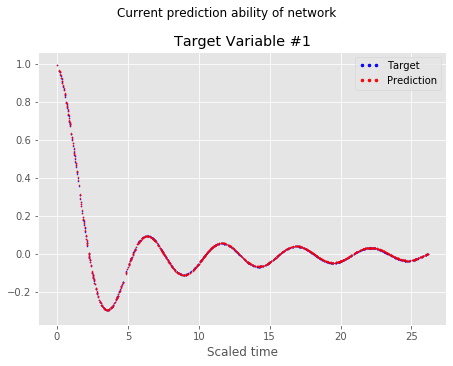

In [32]:
begin_timestamp = datetime.now() # Saves time stamp for beginning of training.
model = run_deepmod(time_tensor, target_tensor, library_config, network_config, optim_config, report_config)

### Results

The discovered model is described below. `model.fit.coeff_vector_history` is an object which contains all coefficients in the working model both just before sparse selection and at the very end of training. In this example this means 2 column vectors are retained. The object is a list containing objects of class ParameterList from the PyTorch framework and so will not display readably unless additional conversion to lists is done. This is purely for display purposes.

`sparsity_mask_list_list` is the associated mask values both before sparse selection and at the very end of training, and identifies the terms each coefficient is associated with.

In [33]:
sparse_coeff_vector_list_list = model.fit.coeff_vector_history
[list(plist) for plist in sparse_coeff_vector_list_list]

[[Parameter containing:
  tensor([[1.3883e-02],
          [1.7464e-01],
          [3.3836e-04],
          [2.3689e-01],
          [1.1936e+00],
          [2.2977e-01],
          [9.9647e-02]], requires_grad=True)]]

In [34]:
sparsity_mask_list_list = model.fit.sparsity_mask_history
sparsity_mask_list_list

[[tensor([0, 1, 2, 3, 4, 5, 6])]]

## Organizing and saving all progress.

### Results Organization

The results of the training process are structured and saved in this section. Series data is organized into NumPy arrays, and any miscellaneous data is grouped into lists of keyed values, in similar fashion to dictionaries.

Some of the series and data saved here could be obtained without explicit saving if `model` is successfully pickled. However, for the sake of convenience, some redundant additional organization and saving occurs.

The below cell arranges results into two similar arrays. The prediction series data is saved both for the prediction obtained purely from the training data, and the prediction the neural network has learnt involving interpolation and perhaps a small amount of extrapolation, for all the data points in the master data set.

In [35]:
prediction_tensor = model.network(time_tensor)
prediction_array = np.array(prediction_tensor.detach())

time_tensor_post = torch.tensor(scaled_time_array, dtype=torch.float32, requires_grad=True)
full_prediction_tensor = model.network(time_tensor_post)
full_prediction_array = np.array(full_prediction_tensor.detach())

Next, arrays containing information on the coefficients associated with different models are organized. Saved are the scaled expected coefficients, the coefficients just before sparse selection, the final coefficients arrived at, the mask identifying these, and the final cofficients with the affects of scaling reversed.

If the model discovery process discovers the expected results, all these arrays will have the same shape except `pre_thresh_coeffs_array` which will always have a shape dictated by the size of the full library.

In [36]:
target_coeffs_array = np.array(expected_coeffs).reshape(-1,1)

pre_thresh_coeffs_array = np.array(sparse_coeff_vector_list_list[0][0].detach())

final_coeffs_array = np.array(sparse_coeff_vector_list_list[-1][0].detach())
sparsity_mask_array = np.array(sparsity_mask_list_list[-1][0]).reshape(-1,1)
unscaled_final_coeffs = VE_params.true_coeffs_from_scaled(final_coeffs_array, time_sf, strain_sf, stress_sf, mask=sparsity_mask_array, library_diff_order=library_diff_order)
true_coeffs_array = np.array(unscaled_final_coeffs).reshape(-1, 1)

Various data series included some of those just organized above are grouped into 2D arrays where comparible series of data make sense.

In [37]:
dg_series_data = np.concatenate((time_array, strain_array, stress_array), axis=1)
NN_series_data = np.concatenate((reduced_time_array, reduced_target_array, prediction_array), axis=1)
final_coeffs_data = np.concatenate((final_coeffs_array, true_coeffs_array, sparsity_mask_array), axis=1)

Next, any further data that was used in the data generation and configuration process within this notebook are organized into themed lists, with keys explaining each datum as part of the same string.

The first such list has already been defined when the model and manipulation were constructed. The result is printed here for display purposes.

In [38]:
dg_info_list

['Model: GMM',
 'E: [1, 1, 1]',
 'eta: [15, 2.5]',
 'Input: Strain',
 'Desc: Half Sinc',
 'omega: 1',
 'Amp: 7']

In [39]:
treatment_info_list = [f'noise_factor: {noise_level}', f'time_sf: {time_sf}', f'strain_sf: {strain_sf}', f'stress_sf: {stress_sf}']
treatment_info_list

['noise_factor: 0',
 'time_sf: 0.8333333333333334',
 'strain_sf: 0.14285714285714285',
 'stress_sf: 0.047619047619047616']

In the below list, each of the different configuration dictionaries are saved. As dictionaries are mutable objects, these will contain any of the default values added when `run_deepmod(...)` was called.

The element identified by the `'input_theta'` key is removed as it makes the resulting list of strings very hard to read. In any case, the full final library is found as `model.library.theta`, although this does not necessarily include all columns of `input_theta`.

In [40]:
library_config.pop('input_theta', None)
config_dict_list = [f'library: {library_config}', f'network: {network_config}', f'optim: {optim_config}', f'report: {report_config}']
config_dict_list

["library: {'library_func': <function mech_library at 0x7f962771c680>, 'diff_order': 3, 'coeff_sign': 1, 'input_type': 'Strain'}",
 "network: {'hidden_dim': 30, 'pre_trained_network': None, 'layers': 4}",
 "optim: {'lr_coeffs': 0.002, 'thresh_func': <function thresh_pc at 0x7f96277357a0>, 'l1': 1e-06, 'PINN': True, 'kappa': 1, 'lr_nn': 0.001, 'betas': (0.9, 0.999), 'amsgrad': False, 'mse_only_iterations': None, 'max_iterations': 100001, 'final_run_iterations': 10001, 'use_lstsq_approx': False}",
 "report: {'plot': True, 'print_interval': 1000}"]

In [41]:
dt_string = begin_timestamp.strftime('%d/%m/%Y %H:%M:%S')
misc_list = ['date_stamp: '+dt_string, f'NumPy_seed: {np_seed}', f'Torch_seed: {torch_seed}']
misc_list

['date_stamp: 23/07/2020 15:58:53', 'NumPy_seed: 2', 'Torch_seed: 0']

### Saving

All data is now saved to the location specified below, within data/Results.

In [42]:
parent_folder = '../data/Results/Synthetic/'
subfolder = f'Abstract/{mech_model} eta {eta} {func_desc} PINN'.replace('.', '-')

foldername = parent_folder + subfolder

In [43]:
if not os.path.isdir(foldername):
    os.makedirs(foldername)

The NumPy arrays are saved in the transferable .csv file format. The headers are an additional row of data at the top of the file preceeded by the `#` symbol. `np.loadtxt(..)` automatically understands this as headers and will not load this row as data, but alternative loaders may behave differently.

In [44]:
np.savetxt(foldername+'/DG_series_data.csv', dg_series_data, delimiter=',', header='Time, Strain, Stress')
np.savetxt(foldername+'/NN_series_data.csv', NN_series_data, delimiter=',', header='Time, Target, Prediction')
np.savetxt(foldername+'/expected_coeffs.csv', target_coeffs_array, delimiter=',', header='Expected_coeffs')
np.savetxt(foldername+'/pre_thresh_coeffs_data.csv', pre_thresh_coeffs_array, delimiter=',', header='Trained_Coeffs')
np.savetxt(foldername+'/final_coeffs_data.csv', final_coeffs_data, delimiter=',', header='Trained_Coeffs, Unscaled, Sparsity_Mask')
np.savetxt(foldername+'/full_prediction.csv', full_prediction_array, delimiter=',', header='Full Prediction')

All lists are saved with each element on a seperate line.

In [45]:
with open(foldername+'/DG_info_list.txt', 'w') as file:
    file.writelines(f'{line}\n' for line in dg_info_list)

In [46]:
with open(foldername+'/treatment_info_list.txt', 'w') as file:
    file.writelines(f'{line}\n' for line in treatment_info_list)

In [47]:
with open(foldername+'/config_dict_list.txt', 'w') as file:
    file.writelines(f'{line}\n' for line in config_dict_list)

In [48]:
with open(foldername+'/misc_list.txt', 'w') as file:
    file.writelines(f'{line}\n' for line in misc_list)

The `model` object is pickled. If any lambda function objects are referred to, in dictionaries for example, this will fail. This does not save the scripts associated with normal functions, just the object identity, and so functions will need to be redefined for successful un-pickling.

In [49]:
with open(foldername+'/model.pickle', 'wb') as file:
    pickle.dump(model, file) # Will fail on dump if using lambda funcs, will fail on load if normal funcs that are not redefined.

### Rediscovering mechanical model parameters if possible

Depending on the results of the model discovery process, it will not always be possible to recover a mechanical model description from the discovered set of coefficients. For this reason, before this is attempted, all other results have been organized and saved. If the discovered model doesn't match the GDM pattern, it is possible that no solution to the set of simultaneous equations exist. One easy check implemented is that an exception is triggered immediately if the the number of coefficients in the discovered model is even (odd counting the assumed first derivative of strain).

However, even in the case a non-viable model is discovered, `model_params_from_coeffs(...)` may still run, but the results will be nonsense.

In [92]:
try: # On exception, continue
    true_coeffs = list(true_coeffs_array.flatten())
    recovered_mech_params = VE_params.model_params_from_coeffs(true_coeffs, mech_model)[0]
    success = True
    print(recovered_mech_params)
    if len(recovered_mech_params) == 0:
        raise
except:
    success = False

No solution possible for coefficient values and model complexity arrived at.
[()]


#### Saving

In [93]:
if success:
    recovered_mech_params = recovered_mech_params[-1] # Take last solution by default
    recovered_mech_params_array = np.array(recovered_mech_params[0]).reshape(-1,1)
    np.savetxt(foldername+'/recovered_mech_params.csv', recovered_mech_params, delimiter=',', header='Recovered')

IndexError: tuple index out of range

## Extra: Post analysis

In this section, a series of analyses are performed regarding the quality and interpretation of the results.

### Viewing the full predictive ability of the trained neural network

The neural network used by DeepMoD was trained only on a subset of the available training data. As a result, unexpected aberrations at points of effective interpolation and extrapolation may be present when a desner prediction is made based on the full input data. To observe if such aberrations are present, such a prediction is hown below against the full available training data. In this synthetic case, the ideal observation is total overlap. Obvious abberations at best imply that the following analysis may have otherwise unexpected incongruous results, and at worse may betray that insufficient traioning data was used if an incorrect model was discovered.

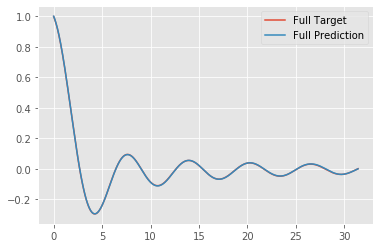

In [72]:
plt.plot(time_array, scaled_target_array, label='Full Target')
plt.plot(time_array, full_prediction_array, label='Full Prediction')
plt.legend()

### Cross-comparison of GDM residuals

In this analysis, the levels of agreement between the two models in question, the expected and the discovered, and the two data sets in question, the target and the prediction, are quantified using the same method as in the Generation Validation section above. To reiterate, the derivatives necessary for each model are calculated numerically for each point in each data series, and the residual present in the equation described by each model is then plotted across the data series, with perfect agreement meaning residuals of 0.

Three combinations are tested here (Model X Data Series):

* Expected X Prediction

* Discovered X Target

* Discovered X Prediction

Expected X Target was already tested in the section Generation Validation as this does not rely on any of the analysis conducted within DeepMoD.

#### Expected X Prediction

The generated data series for the manipulation is still used as no prediction for this is made, and it is unambiguously defined as part of the problem to be solved.

In [73]:
if input_type == 'Strain':
    errors = VE_datagen.equation_residuals(scaled_time_array, scaled_strain_array, full_prediction_array, expected_coeffs)
else:
    errors = VE_datagen.equation_residuals(scaled_time_array, full_prediction_array, scaled_stress_array, expected_coeffs)

As a quick comparison, the mean residual is calculated. This excludes teh extreme points as the numerical derivatives at these points will be relatively inaccurate.

In [74]:
np.mean(abs(errors[library_diff_order:-library_diff_order]))

0.0040524402336372806

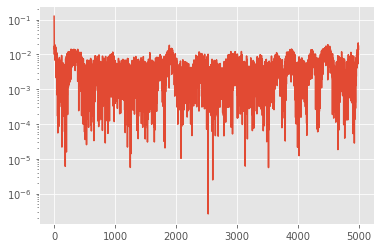

In [75]:
plt.semilogy(abs(errors.flatten()))

#### Discovered X Target

Unlike before, as the terms included in the discovered model cannot be assumed from the number of terms, the sparsity mask must be included when `equation_residuals(...)` is called so that a residual based on the terms selected in the discovered model can be calculated.

In [76]:
errors = VE_datagen.equation_residuals(scaled_time_array, scaled_strain_array, scaled_stress_array, final_coeffs_array, sparsity_mask=sparsity_mask_array, diff_order=library_diff_order)

In [77]:
np.mean(abs(errors[library_diff_order:-library_diff_order]))

0.001180964454143063

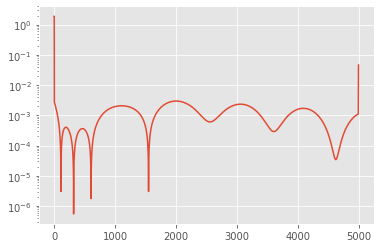

In [78]:
plt.semilogy(abs(errors.flatten()))

#### Discovered X Prediction

In [79]:
if input_type == 'Strain':
    errors = VE_datagen.equation_residuals(scaled_time_array, scaled_strain_array, full_prediction_array, final_coeffs_array, sparsity_mask=sparsity_mask_array, diff_order=library_diff_order)
else:
    errors = VE_datagen.equation_residuals(scaled_time_array, full_prediction_array, scaled_stress_array, final_coeffs_array, sparsity_mask=sparsity_mask_array, diff_order=library_diff_order)

In [80]:
np.mean(abs(errors[library_diff_order:-library_diff_order]))

0.013864272908868318

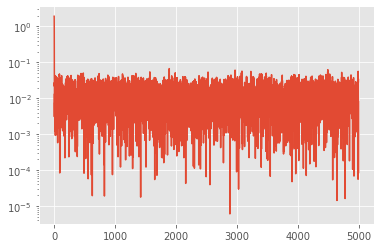

In [81]:
plt.semilogy(abs(errors.flatten()))

### Reformulation of response from discovered model.

In this final analysis, a response curve is synthesized as a numerical solution to the discovered model, with no reference to the defined model, to examine in another way whether any differences between the models expected and discovered are manifested in a meaningful way.

This analysis is not based on Boltzmann integrals and the differential equation is solved directly and numerically by the SciPy implemented numerical solver `odeint(...)` within the `scipy.integrate` package, and based on FORTRAN libraries.

Intial values for this analysis are obtained from automatic differentiation based on the linked tensors provided to `calculate_int_diff_equation(...)`.

The derivatives for the manipulation variable are obtained numerically in this process, with the primary focus being on solving for the response variable.

In [82]:
response_recalc = VE_datagen.calculate_int_diff_equation(time_tensor_post, full_prediction_tensor, scaled_input_expr, final_coeffs_array, sparsity_mask_array, library_diff_order, input_type)

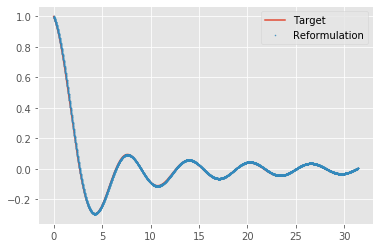

In [83]:
plt.plot(time_array.flatten(), scaled_target_array.flatten(), label='Target')
plt.plot(time_array.flatten(), response_recalc.flatten(), label='Reformulation', marker='.', markersize=1, linestyle='None')
plt.legend()